# Classification of two cancer types based on gene expression

In [1]:
import os
for dirname, _, filenames in os.walk('/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/clustering.ipynb
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/data_set_ALL_AML_independent.csv
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/.gitattributes
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/Classification_of_Cancer_by_Gene_Expression_Dataset.ipynb
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/README.txt
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/actual.csv
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/data_set_ALL_AML_train.csv
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/.git/HEAD
/home/intellisense/Documents/GitHub/Classification_of_Cancer_by_Gene_Expression_Dataset/.git/description
/home/int

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [3]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set_theme(style="darkgrid")
np.random.seed(42)

In [4]:
warnings.filterwarnings("ignore")

In [5]:
le = LabelEncoder()

### Load data

In [6]:
train_data = pd.read_csv("data_set_ALL_AML_train.csv")
test_data = pd.read_csv("data_set_ALL_AML_independent.csv")
labels = pd.read_csv("actual.csv", index_col = 'patient')

In [7]:
train_data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [8]:
test_data.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [10]:
cols_train = [col for col in train_data.columns if "call" in col]
cols_test = [col for col in test_data.columns if "call" in col]

train_data.drop(cols_train, axis=1, inplace=True)
test_data.drop(cols_test, axis=1, inplace=True)

In [11]:
train_data = train_data.T
test_data = test_data.T

In [12]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [13]:
train_data.columns = test_data.iloc[1].values
train_data.drop(["Gene Description", "Gene Accession Number"], axis=0, inplace=True)
test_data.columns = test_data.iloc[1].values
test_data.drop(["Gene Description", "Gene Accession Number"], axis=0, inplace=True)

In [14]:
train_data.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [15]:
# Adding new column
train_data["patient"] = train_data.index.values
test_data["patient"] = test_data.index.values

In [16]:
train_data.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,1
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,2
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,3
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,4
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,5


In [17]:
train_data = train_data.astype("int32")
test_data = test_data.astype("int32")

In [18]:
labels["cancer"] = le.fit_transform(labels["cancer"])
train_data = pd.merge(train_data, labels, on="patient")
test_data = pd.merge(test_data, labels, on="patient")

In [19]:
train_data["cancer"].value_counts()

cancer
0    27
1    11
Name: count, dtype: int64

In [20]:
test_data["cancer"].value_counts()

cancer
0    20
1    14
Name: count, dtype: int64

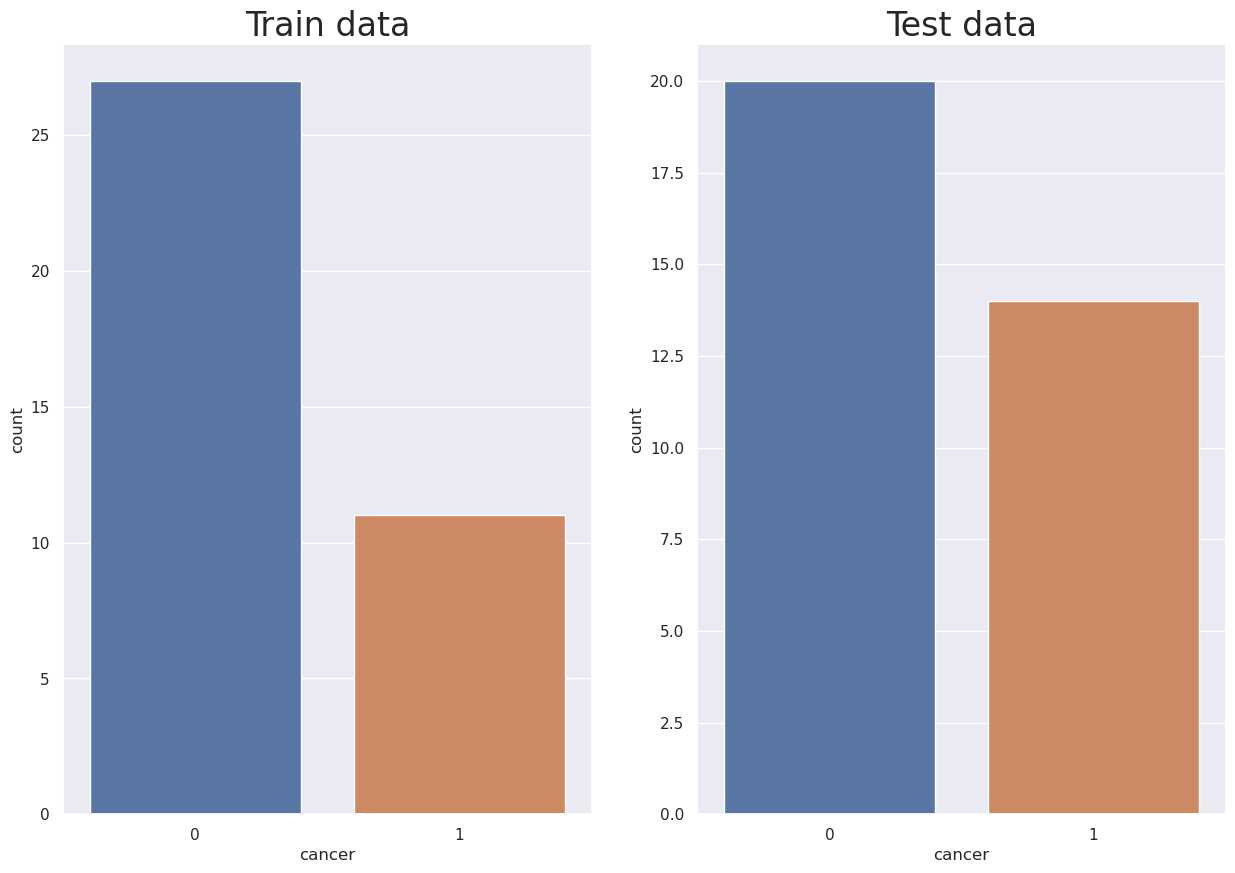

In [21]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="cancer", data=train_data, ax=axs[0])
axs[0].set_title("Train data", fontsize=24)
sns.countplot(x="cancer", data=test_data, ax=axs[1])
axs[1].set_title("Test data", fontsize=24)
plt.show()

In [22]:
upsampled_data = random.sample(train_data.query("cancer == 1")["patient"].index.to_list(), k=8, )

In [23]:
upsampled_data

[37, 35, 29, 34, 30, 31, 32, 27]

In [24]:
train_data_upsampled = pd.concat([train_data, train_data.iloc[upsampled_data, :]])

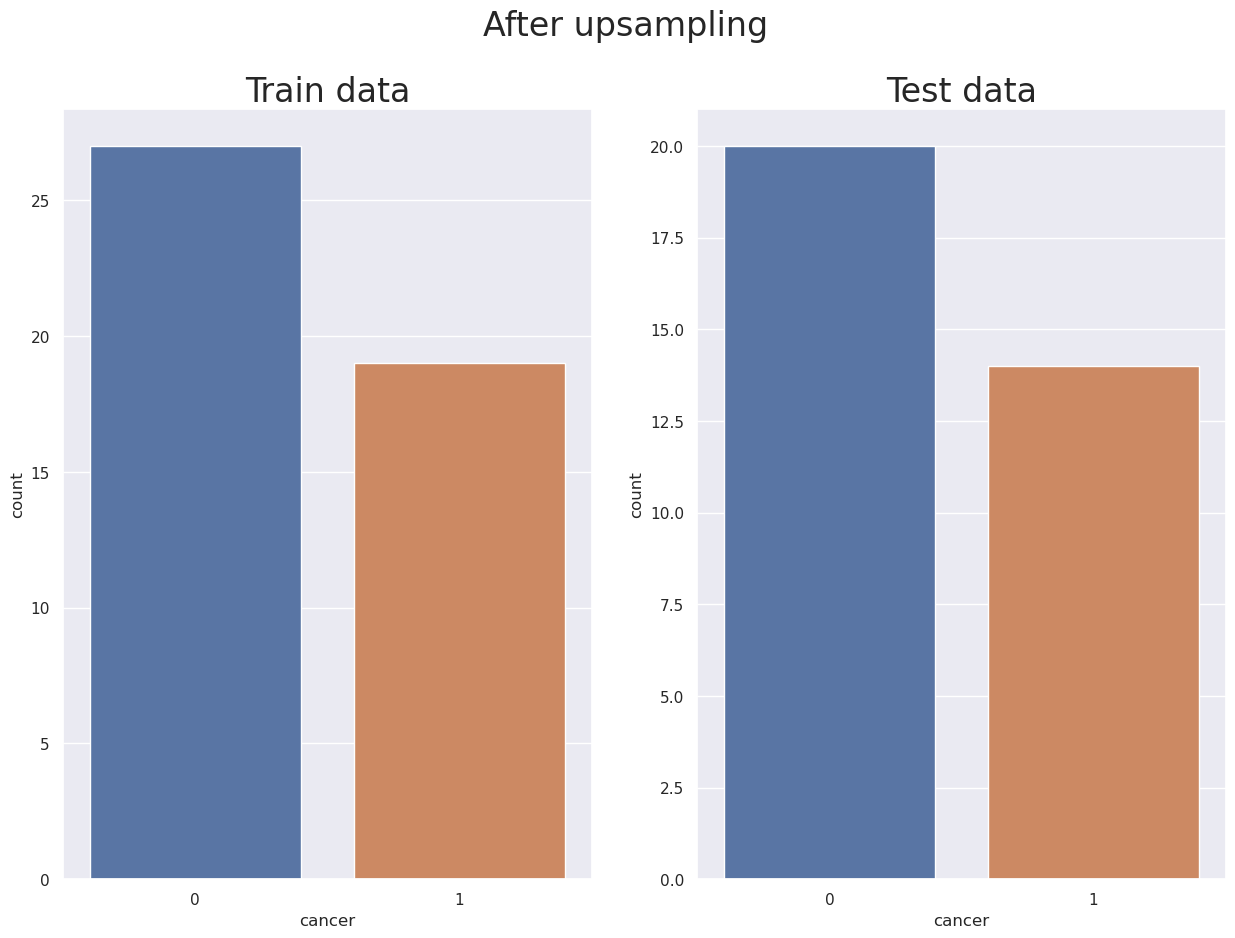

In [25]:
fig, axs = plt.subplots(1, 2)
sns.countplot(x="cancer", data=train_data_upsampled, ax=axs[0])
axs[0].set_title("Train data", fontsize=24)
sns.countplot(x="cancer", data=test_data, ax=axs[1])
axs[1].set_title("Test data", fontsize=24)
fig.suptitle("After upsampling", fontsize=24)
plt.show()

In [26]:
X_train = train_data_upsampled.drop(columns=["patient", "cancer"])
y_train = train_data_upsampled["cancer"]
X_test = test_data.drop(columns=["patient", "cancer"])
y_test = test_data["cancer"]

In [27]:
# Features scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [28]:
reduced_train = PCA().fit_transform(X_train_scaled)
kmeans = KMeans(n_clusters=2, n_init=20)
kmeans.fit(train_data_upsampled)

KMeans(n_clusters=2, n_init=20)

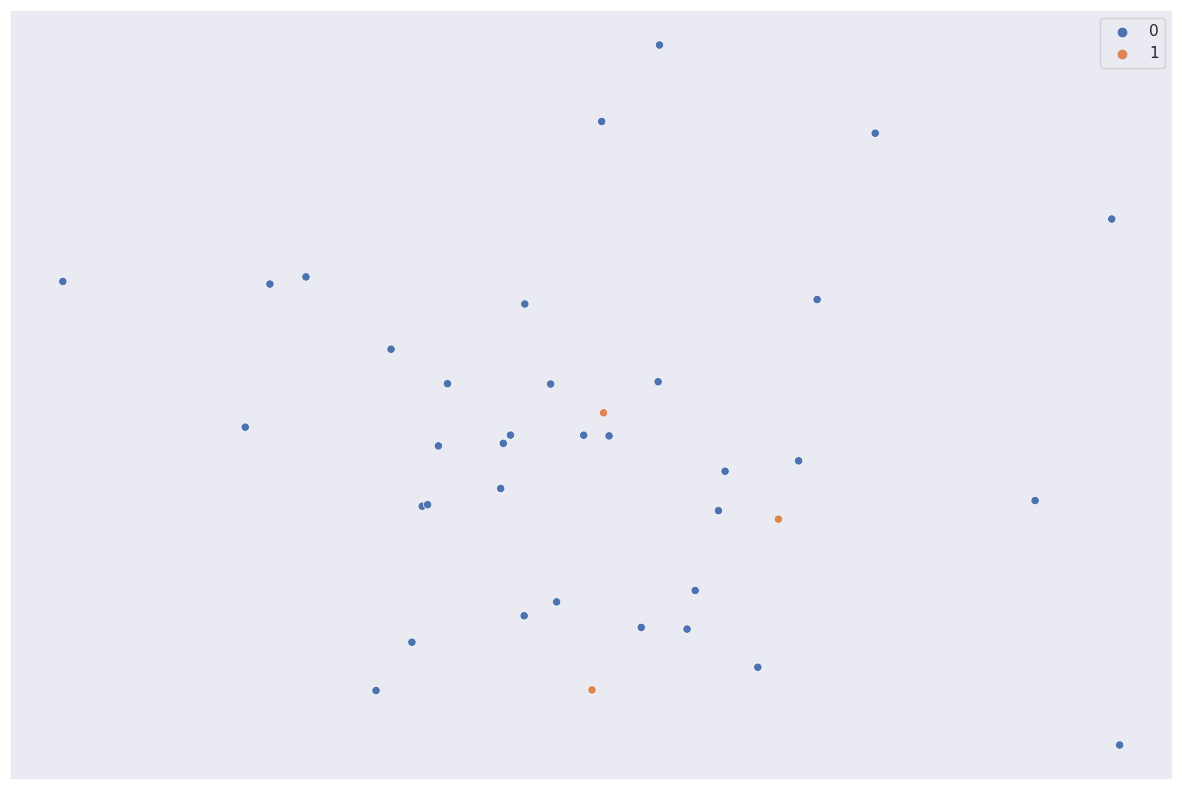

In [29]:
sns.scatterplot(x=reduced_train[0], y=reduced_train[1], hue=kmeans.labels_)
plt.xticks(())
plt.yticks(())
plt.show()

27 features explain around 90% of the variance. From 7129 features to 27


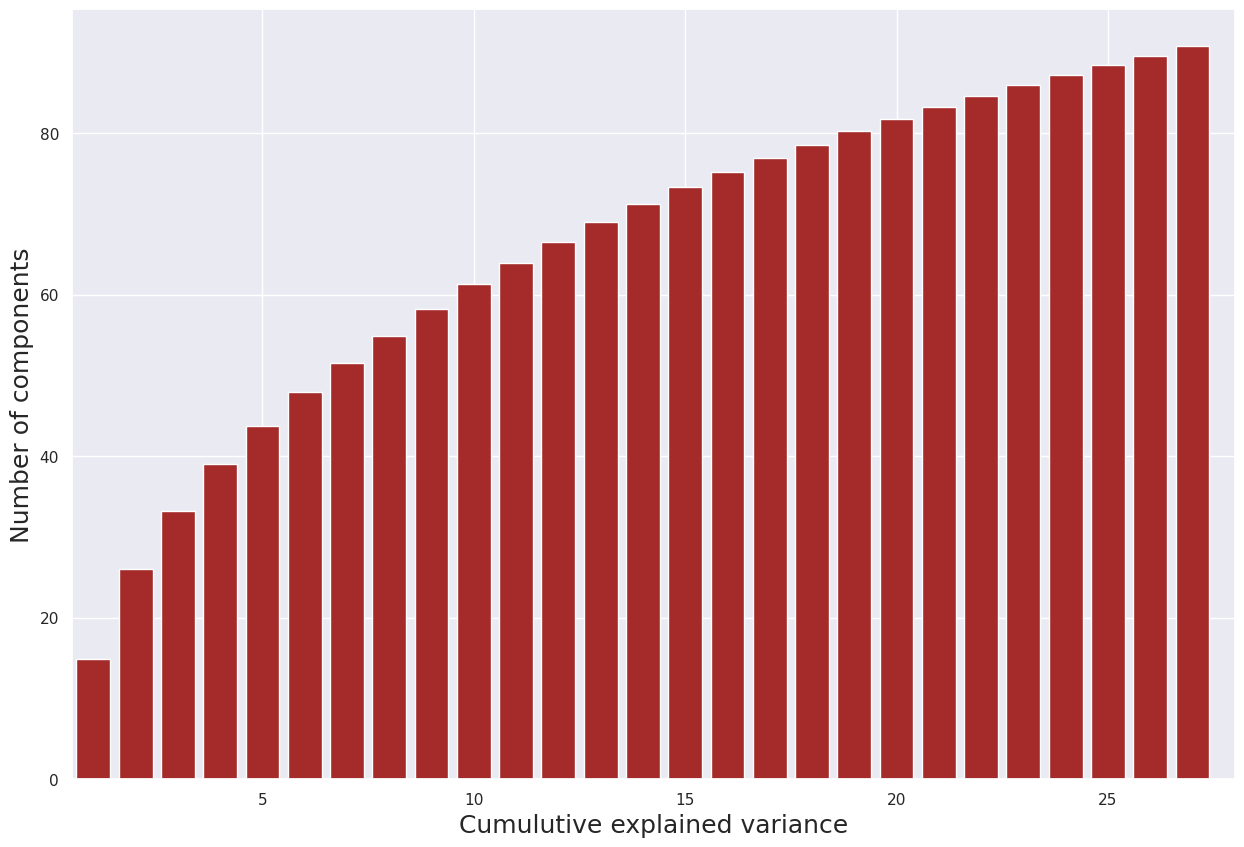

In [30]:
pca = PCA()
pca.fit_transform(X_train_scaled)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance / total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1   
print(k, " features explain around 90% of the variance. From 7129 features to ", k, sep='')

pca = PCA(n_components=k)
X_train_pca = pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(1, k + 1), var_exp, color="brown")
plt.xlabel("Cumulutive explained variance", fontsize=18)
plt.ylabel("Number of components", fontsize=18)
plt.xlim((0.5, k + 1))
plt.show()

In [31]:
cancer_labels = train_data_upsampled["cancer"].map({0: le.classes_[0], 1: le.classes_[1]}).values
patient_labels = np.array(list(map(str, train_data_upsampled["patient"].values))).astype("object") + "_" + cancer_labels

In [32]:
link = linkage(X_train_scaled, 'ward', 'euclidean')

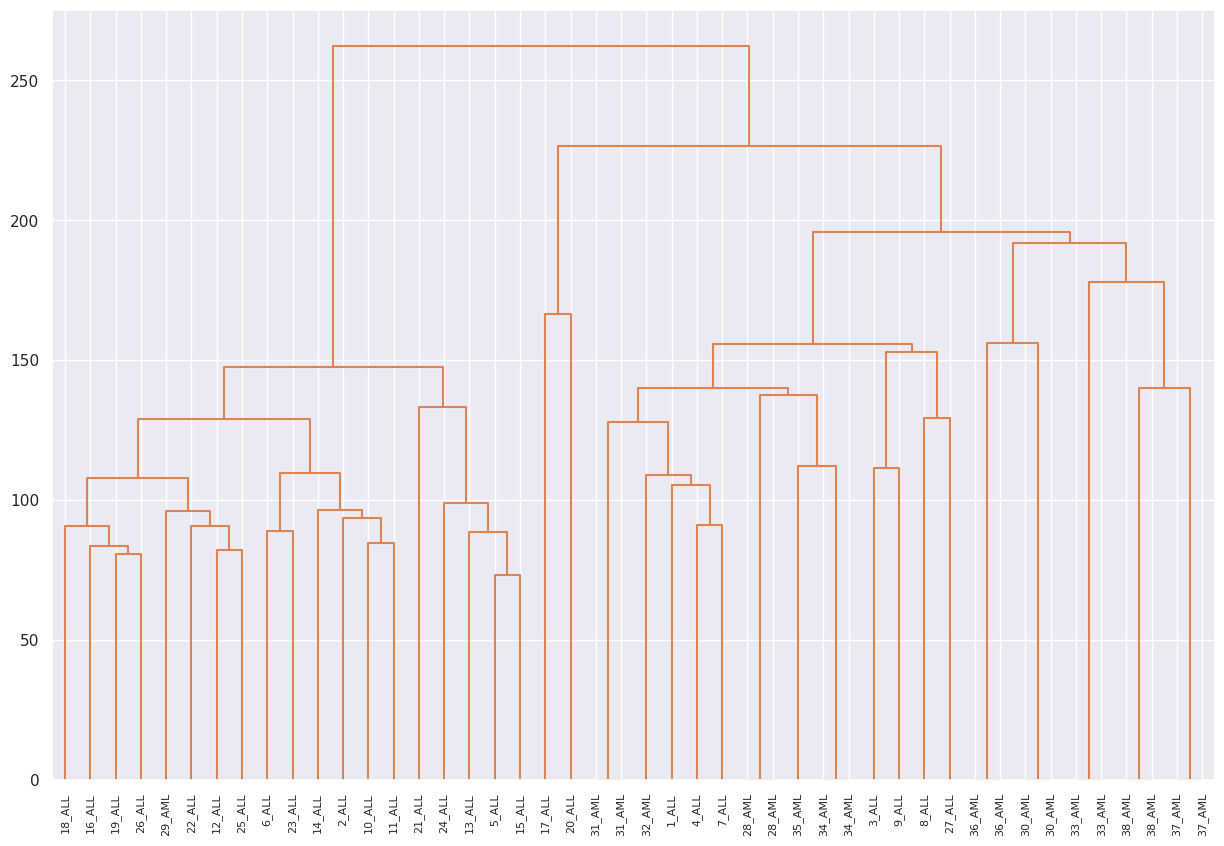

In [33]:
dm = dendrogram(link, color_threshold=1250, labels=patient_labels)

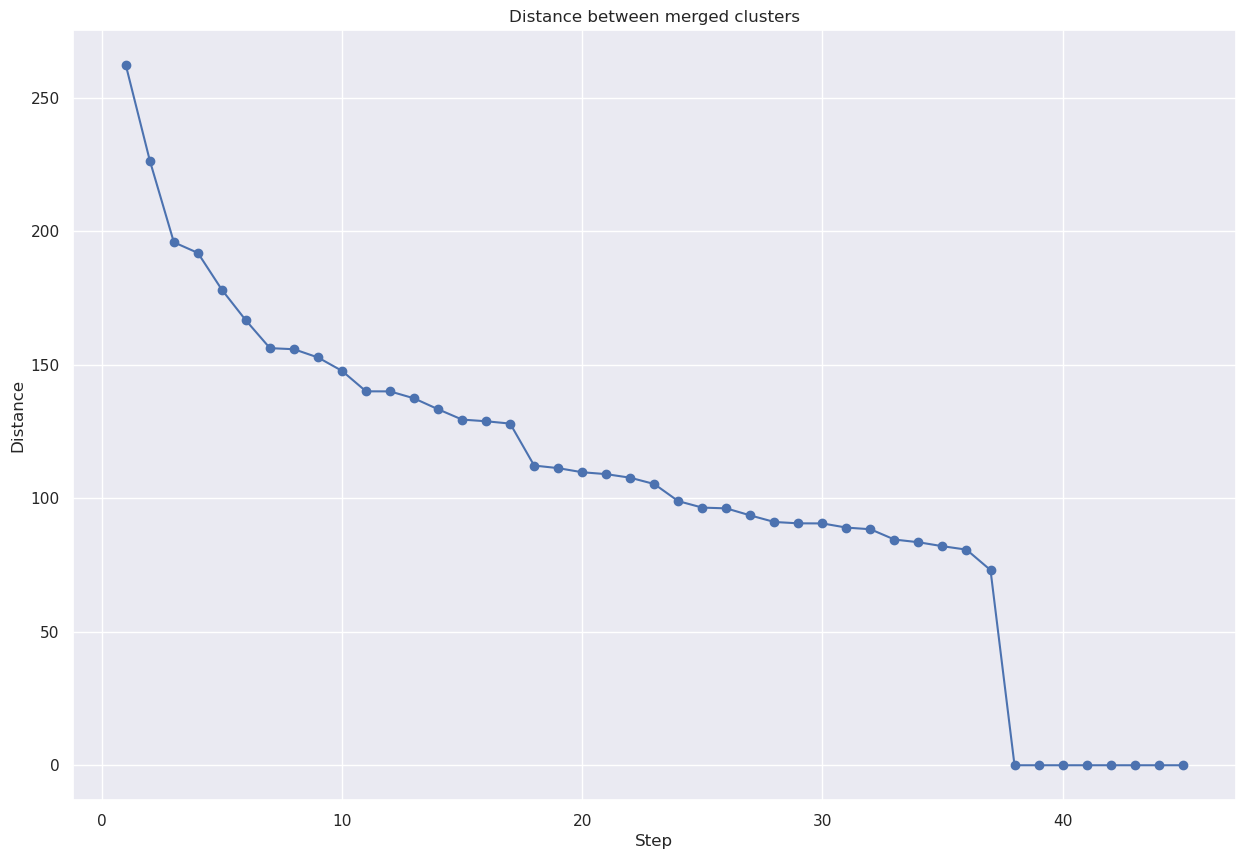

In [34]:
dist = link[:, 2]
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Distance between merged clusters')
plt.xlabel('Step')
plt.ylabel('Distance')
plt.show()

## Random forest

In [35]:
rf_params = {"bootstrap": [False, True],
             "n_estimators": [60, 70, 80, 90, 100],
             "max_features": [0.6, 0.65, 0.7, 0.75, 0.8],
             "min_samples_leaf": [8, 10, 12, 14],
             "min_samples_split": [3, 5, 7]
        }

rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring="f1")
rf_search.fit(X_train_scaled, y_train)
best_rf = rf_search.best_estimator_

In [36]:
best_rf

RandomForestClassifier(max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=60)

Validation f1-score of RandomForest Classifier is 0.9285714285714286

Classification report :
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.93      0.93      0.93        14

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34



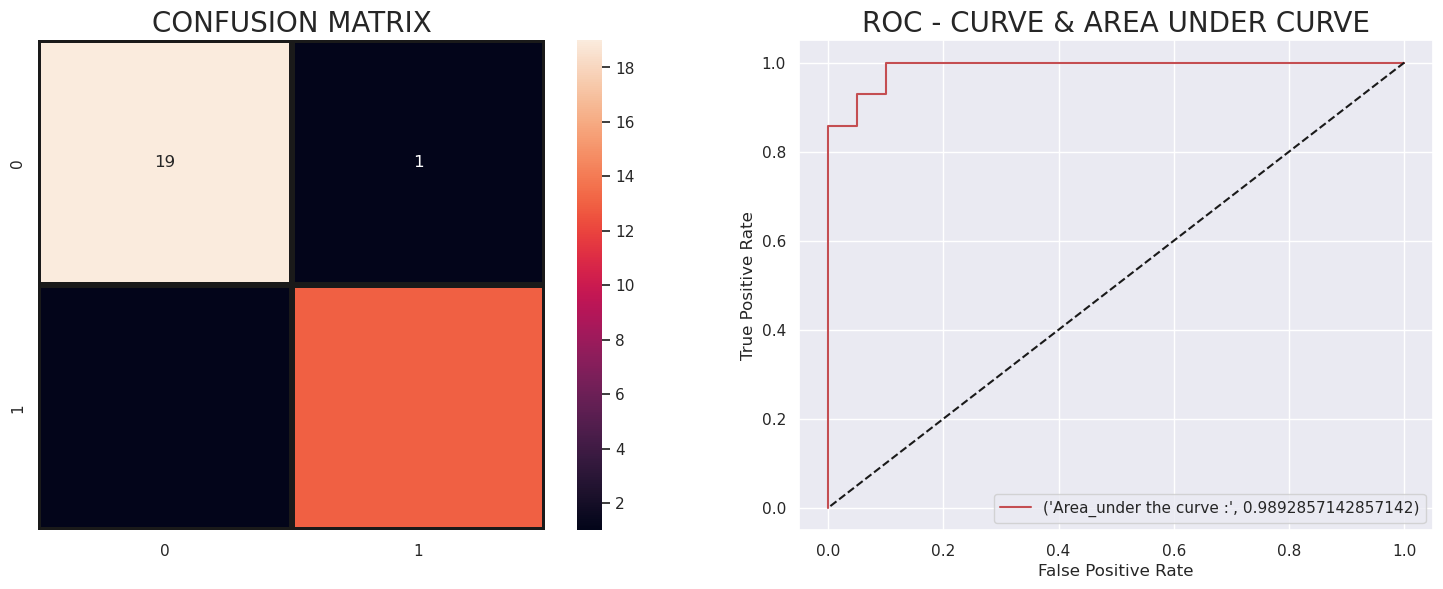

In [37]:
rf_prediction = best_rf.predict(X_test_scaled)


f1_score = metrics.f1_score(y_test, rf_prediction)
print('Validation f1-score of RandomForest Classifier is', f1_score)
print ("\nClassification report :\n", metrics.classification_report(y_test, rf_prediction))

# Confusion matrix
plt.figure(figsize=(18, 14))
plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, rf_prediction), annot=True, fmt = "d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC curve
rf_predicted_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label = ("Area_under the curve :", metrics.auc(fpr, tpr)), color = "r")
plt.plot([1,0], [1,0], linestyle = "dashed", color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
plt.show()

In [38]:
print(f"Quantity of features with 0 importance: {(best_rf.feature_importances_ == 0).sum()}")

Quantity of features with 0 importance: 7104


In [39]:
! pip install shap

import shap

In [40]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)


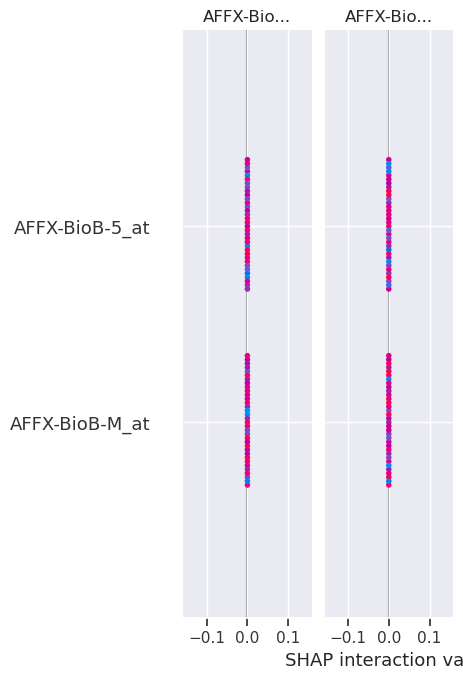

In [41]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [42]:
mask = (best_rf.feature_importances_ != 0)
importances = best_rf.feature_importances_[mask]
feature_names = train_data.columns.values[:7129][mask]

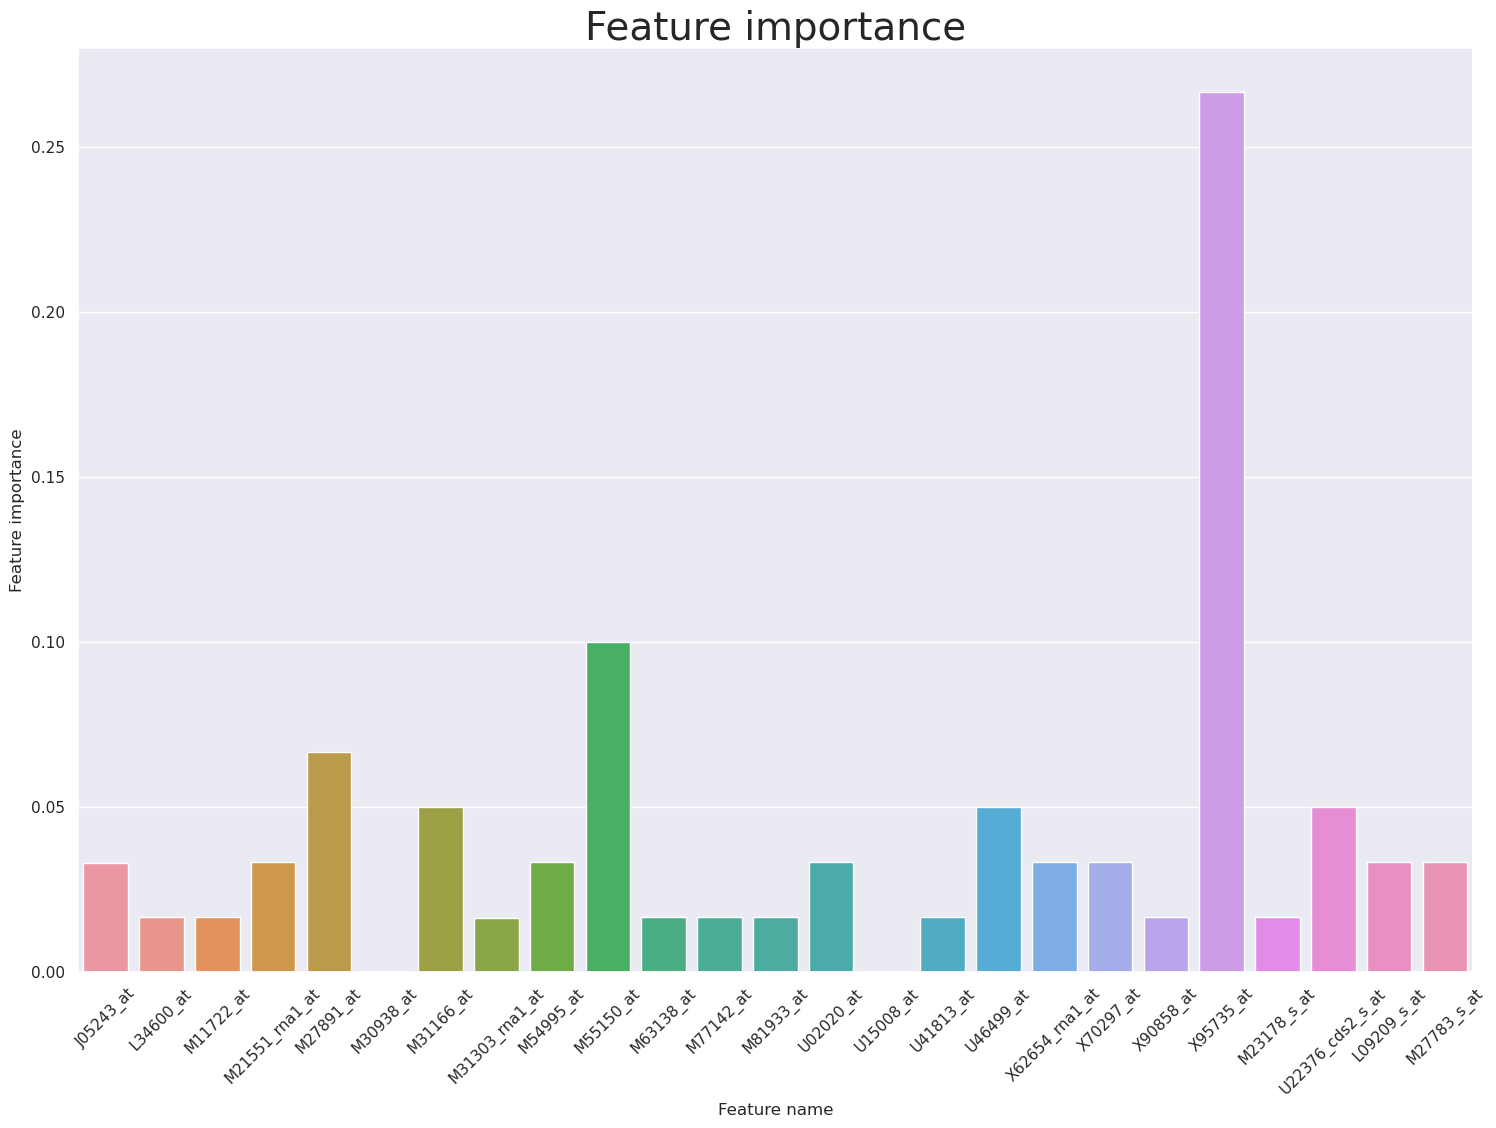

In [43]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
sns.barplot(x=feature_names, y=importances)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.title("Feature importance", fontsize=28)
ax.set_xticklabels(feature_names, rotation = 45)
plt.show()

In [44]:
print(metrics.accuracy_score(y_test, rf_prediction))

0.9411764705882353


## KNN

In [45]:
knn_params = {
    "n_neighbors": [i for i in range(1, 30, 5)],
    "weights": ["uniform", "distance"],
    "algorithm": ["kd_tree"],
    "leaf_size": [1, 10, 20, 30],
    "p": [1, 2]
}
knn_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, verbose=1, scoring="f1")
knn_search.fit(X_train_scaled, y_train)
best_knn = knn_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [46]:
best_knn

KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=6, p=1,
                     weights='distance')

best_knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=1, n_neighbors=6, p=1,
                     weights='distance')

## XGBOOST

In [47]:
xgb_params = {"max_depth": [3, 4, 5, 6, 7, 8, 10, 12],
              "min_child_weight": [1, 2, 4, 6, 8, 10, 12, 15],
              "n_estimators": [40, 50, 60, 70, 80, 90, 100, 110, 120, 130],
              "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]}
xgb_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_params, scoring="f1")
xgb_search.fit(X_train_scaled, y_train)
best_xgb = xgb_search.best_estimator_

In [48]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=40, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Naive Bayes

In [49]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_scaled, y_train)

GaussianNB()

## Logistic Regression

In [50]:
lr_params = {"C": [1e-03, 1e-2, 1e-1, 1, 10], 
      "penalty": ["l1", "l2"]}
log_refr_search = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_params, scoring="f1")
log_refr_search.fit(X_train_scaled, y_train)
best_lr = log_refr_search.best_estimator_

In [51]:
best_lr

LogisticRegression(C=0.001)

best_lr = LogisticRegression(C=0.001)

## Decision Tree

In [52]:
dt_params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5, 6], 'max_depth':[3,4,5,6,7,8]}
dst_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=dt_params, verbose=1, cv=3, scoring="f1")
dst_search.fit(X_train_scaled, y_train)
best_dt = dst_search.best_estimator_

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


In [53]:
print(f"Quantity of features with 0 importance: {(best_dt.feature_importances_ == 0).sum()}")

mask_dt = (best_dt.feature_importances_ != 0)
importances_dt = best_dt.feature_importances_[mask_dt]
feature_names_dt = train_data.columns.values[:7129][mask_dt]

Quantity of features with 0 importance: 7128


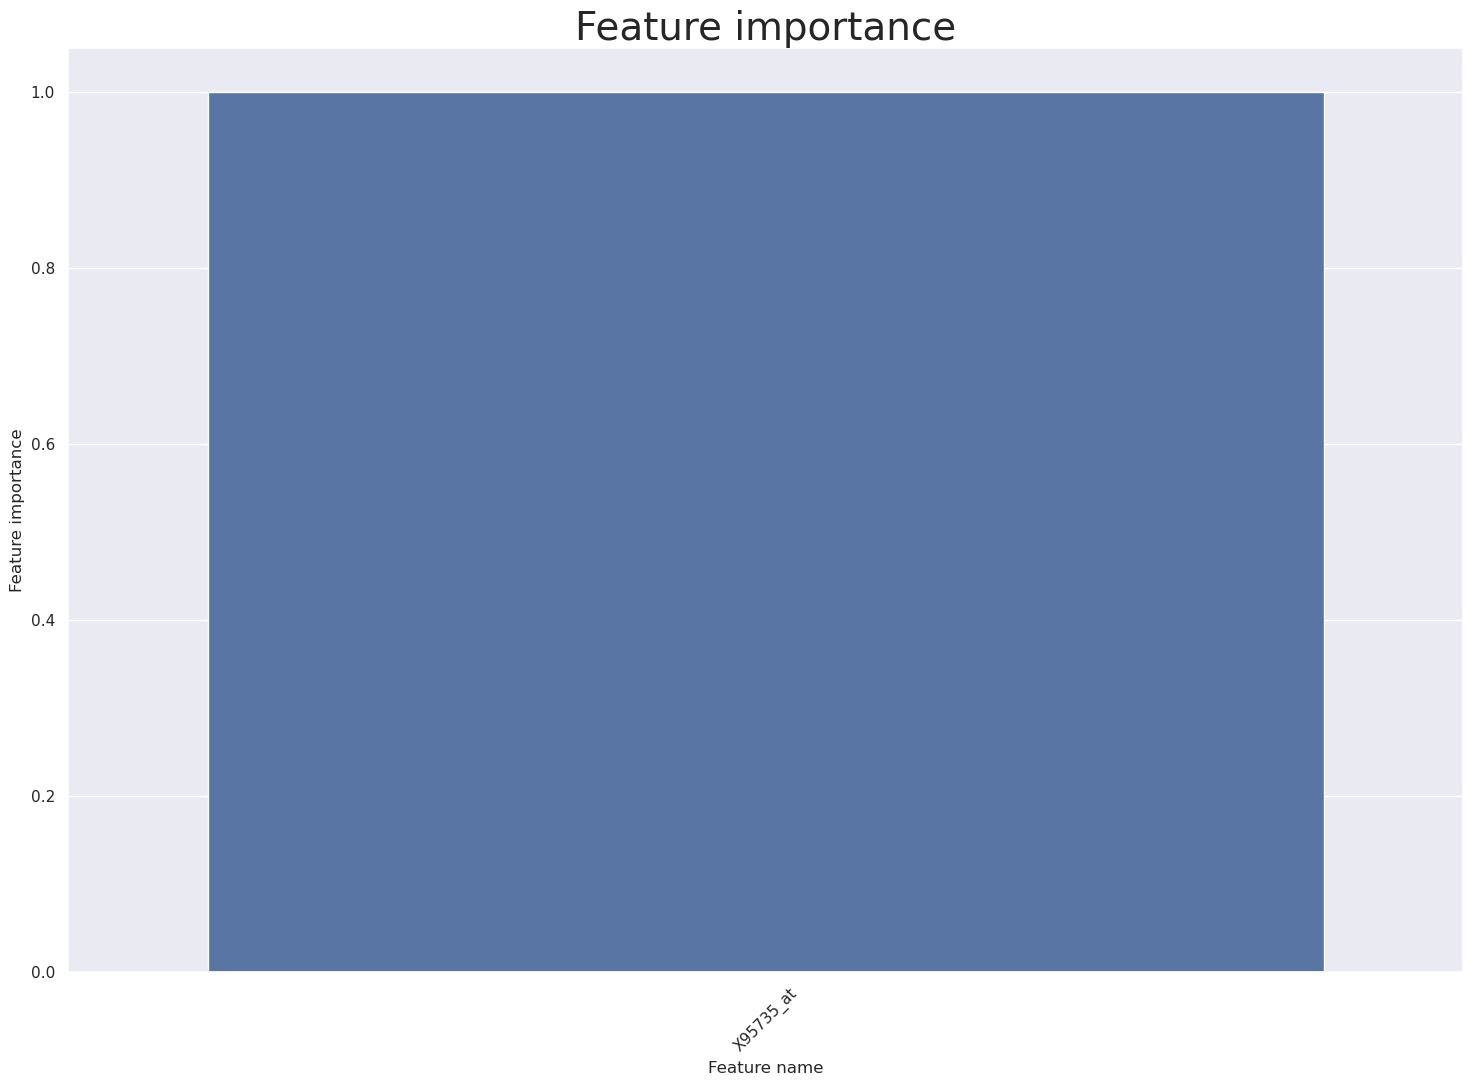

In [54]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111)
sns.barplot(x=feature_names_dt, y=importances_dt)
plt.ylabel("Feature importance")
plt.xlabel("Feature name")
plt.title("Feature importance", fontsize=28)
ax.set_xticklabels(feature_names_dt, rotation = 45)
plt.show()

## SVC

In [55]:
svc_params = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
svc_search = GridSearchCV(SVC(probability=True), param_grid=svc_params, n_jobs=-1, verbose=1, scoring="f1")
svc_search.fit(X_train_scaled, y_train)
best_svc = svc_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


## Voting Classifier

In [56]:
rf_f1_score = metrics.f1_score(y_test, best_rf.predict(X_test_scaled))
knn_f1_score = metrics.f1_score(y_test, best_knn.predict(X_test_scaled))
nb_clf_f1_score = metrics.f1_score(y_test, nb_clf.predict(X_test_scaled))
lr_f1_score = metrics.f1_score(y_test, best_lr.predict(X_test_scaled))
dt_f1_score = metrics.f1_score(y_test, best_dt.predict(X_test_scaled))
svc_f1_score = metrics.f1_score(y_test, best_svc.predict(X_test_scaled))
xgb_f1_score = metrics.f1_score(y_test, best_xgb.predict(X_test_scaled))

In [57]:
model_f1_scores = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'Naive Bayes', 'XGBoost'],

    'f1-value': [svc_f1_score, knn_f1_score, lr_f1_score, dt_f1_score, 
              rf_f1_score, nb_clf_f1_score, xgb_f1_score]})
model_f1_scores.sort_values(by='f1-value', ascending=False)

,Model,f1-value
4,Random Forest,0.928571
3,Decision Tree,0.896552
5,Naive Bayes,0.896552
6,XGBoost,0.896552
0,Support Vector Machines,0.833333
2,Logistic Regression,0.727273
1,KNN,0.636364


In [58]:
mean_f1_score = np.mean([rf_f1_score, knn_f1_score, nb_clf_f1_score, lr_f1_score, dt_f1_score, svc_f1_score, xgb_f1_score])
weight_rf = rf_f1_score / mean_f1_score
weight_knn = knn_f1_score / mean_f1_score
weight_nb = nb_clf_f1_score / mean_f1_score
weight_lr = lr_f1_score / mean_f1_score
weight_dt = dt_f1_score / mean_f1_score
weight_svc = svc_f1_score / mean_f1_score
weight_xgb = xgb_f1_score / mean_f1_score

In [59]:
model_weights = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 'Decision Tree',
              'Random Forest', 'Naive Bayes', 'XGBoost'],

    'weight': [weight_svc, weight_knn, weight_lr, weight_dt, 
              weight_rf, weight_nb, weight_xgb]})
model_weights.sort_values(by='weight', ascending=False)

,Model,weight
4,Random Forest,1.117761
3,Decision Tree,1.079218
5,Naive Bayes,1.079218
6,XGBoost,1.079218
0,Support Vector Machines,1.003119
2,Logistic Regression,0.875449
1,KNN,0.766018


In [60]:
ensemble = VotingClassifier(estimators=[("rf", best_rf), ("knn", best_knn), ("nb", nb_clf), ("lr", best_lr), ("dt", best_dt), ("svc", best_svc)],
                                        voting="soft", weights=[weight_rf, weight_knn, weight_nb, weight_lr, weight_dt, weight_svc])

In [61]:
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_features=0.6,
                                                     min_samples_leaf=8,
                                                     min_samples_split=3,
                                                     n_estimators=60)),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=1, n_neighbors=6,
                                                   p=1, weights='distance')),
                             ('nb', GaussianNB()),
                             ('lr', LogisticRegression(C=0.001)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=3,
                                                     max_leaf_nodes=2,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=1, kernel='linear', probability=True))],
                 voting='soft',
                 weights=[1.1177610637642468, 0.7660180716706027,
                          1.079217578806859, 0.8754492247664031,
                          1.079217578806859, 1.00311890337817])

Validation f1-score of Ensemble Classifier is 0.962962962962963

Classification report :
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.93      0.96        14

    accuracy                           0.97        34
   macro avg       0.98      0.96      0.97        34
weighted avg       0.97      0.97      0.97        34



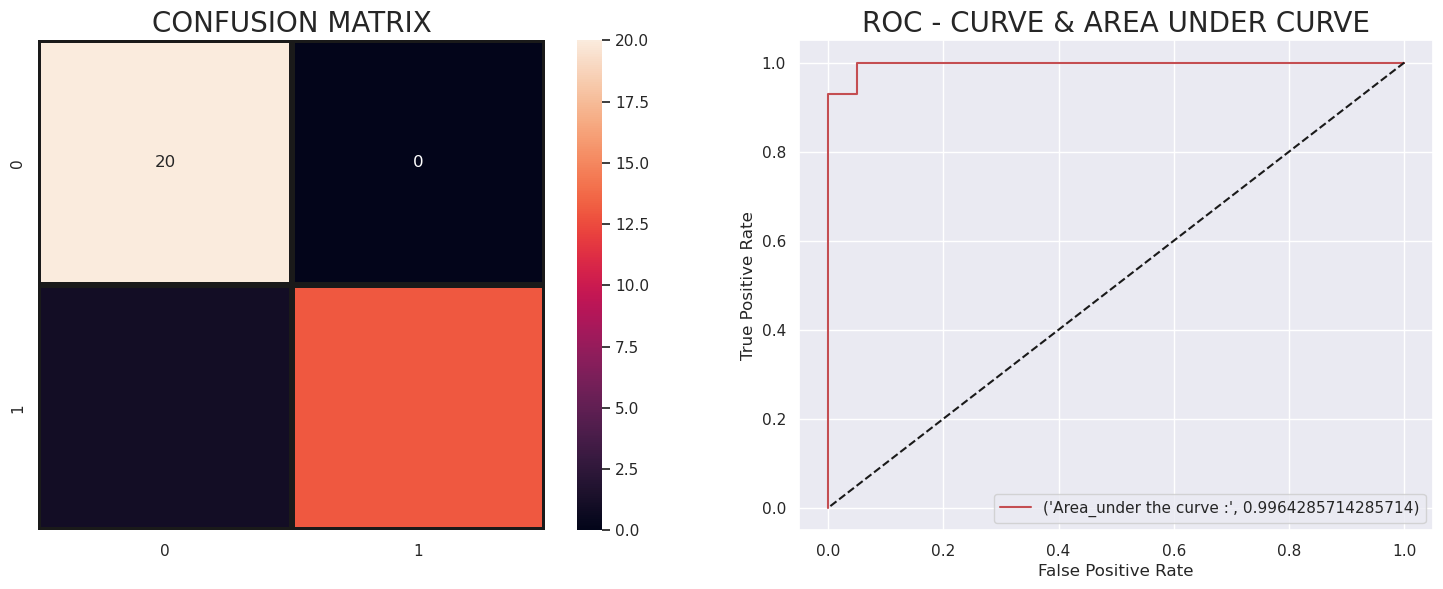

In [62]:
ens_prediction = ensemble.predict(X_test_scaled)
f1_score = metrics.f1_score(y_test, ens_prediction)
print('Validation f1-score of Ensemble Classifier is', f1_score)
print ("\nClassification report :\n", metrics.classification_report(y_test, ens_prediction))

# Confusion matrix
plt.figure(figsize=(18, 14))
plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, ens_prediction), annot=True, fmt = "d", linecolor="k", linewidths=3)
plt.title("CONFUSION MATRIX", fontsize=20)

# ROC curve
ens_predicted_probs = ensemble.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, ens_predicted_probs)
plt.subplot(222)
plt.plot(fpr, tpr, label = ("Area_under the curve :", metrics.auc(fpr, tpr)), color = "r")
plt.plot([1,0], [1,0], linestyle = "dashed", color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)
plt.show()